In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import soundfile

import random
from itertools import cycle
import librosa

import warnings
warnings.filterwarnings("ignore")

from composition.common import (
    sinusoid, sweeping_sinusoid, line_segment, constant, triangle, square, adsr,
    to_db_loudness, generate_audio, autotune, SECOND, get_t, autotune_explicit
)

# Required for restoring loudness statistics, even though it is not used in this notebook.
from utils import QuantileTransformer

plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
def show(pitch, loudness):
    steps = len(loudness)
    dur = steps / SECOND
    t = np.linspace(0, dur, steps)
    
    fig,ax = plt.subplots()
    ax2=ax.twinx()
    
    ax.plot(t, loudness, color='red')
    ax2.plot(t, pitch, color='blue')

In [4]:
def make_part(instrument, pitch, loudness, db_offset):
    #we can save and restore all parameters for generating score later
    return {
        'instrument': instrument,
        'pitch': pitch,
        'loudness': loudness,
        'db_offset': db_offset,
    }

In [5]:
def pad(xs, duration):
    start = constant(duration, xs[0])
    end = constant(duration, xs[-1])
    
    return np.concatenate([start, xs, end])

In [6]:
def scale_from_intervals(intervals):
    steps = cycle(intervals)
    scale = [0]

    while scale[-1] < 120:
        scale.append(scale[-1] + next(steps))
    
    return np.array(scale, dtype='int')

In [7]:
def harmonics_to_cents(harmonics):
    ratios = [b / a for a, b in zip(harmonics[:-1], harmonics[1:])]
    cents = [np.log2(x)*12 for x in ratios]
    
    return cents

- Violin 55-103
- Viola 48-91
- Cello 36-76
- Flute 60-96
- Flute2 55-91

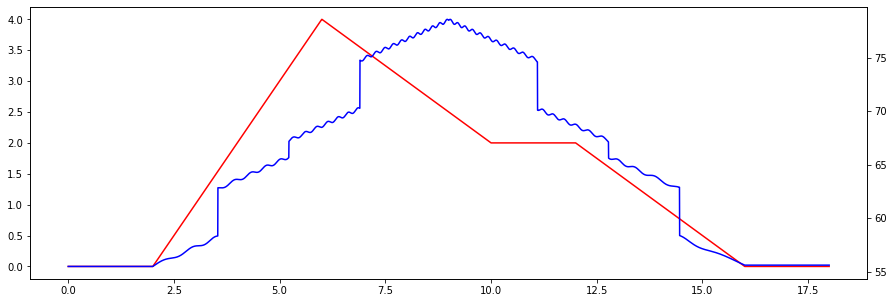

In [8]:
duration = 14
padding = constant(2, 1)
phi = (np.sqrt(5) + 1) / 2

# loudness = triangle(duration, 2, 0.25)
# loudness += line_segment(duration, 0, 2)
loudness = adsr(4, 4, 2, 4, 1, 0.5)
loudness = np.concatenate([padding * 0, loudness, padding * 0]) * 4

# pitch = line_segment(duration, 55, 80)
# pitch = sweeping_sinusoid(duration, 0.05, 2, 55, np.linspace(8, 0, int(duration*SECOND)), -0.25)
pitch= triangle(duration, 1/duration, 0.5, lowest=55, highest=80)

# intervals = [3, 7, 4, 8, 5, 9]
# scale = scale_from_intervals(intervals)
harmonics = [5, 10, 15, 20, 25]
intervals = harmonics_to_cents(harmonics)
scale= scale_from_intervals(intervals)
scale = (scale - 55) % 120
pitch = autotune_explicit(pitch, 0.5, scale)

modulation = np.concatenate([
    sweeping_sinusoid(duration / 2, 1, 6, 0, 0.15),
    sweeping_sinusoid(duration / 2, 6, 0.1, 0, 0.15)
])
pitch += modulation

pitch = np.concatenate([padding * pitch[0], pitch, padding * pitch[-1]])

show(pitch, loudness)

In [9]:
part = make_part('violin', pitch, loudness, -12)
audio = generate_audio(**part)
Audio(audio, rate=16000)

In [10]:
def my_mother(duration_range=(0.1, 0.2), repeats=100):
    envelopes = []
    for i in range(repeats):
        duration = np.random.uniform(*duration_range)
        bp = np.random.uniform(0, duration, 4)
        pv = np.random.uniform(0.1, 2, 2)
        bp.sort()
        pv.sort()
        envelopes.append(adsr(bp[0], bp[1], bp[2], bp[3], pv[1], pv[0]))
        # envelopes.append(triangle(duration, 1/duration, highest=np.random.uniform(0.1, 2)))

    loudness = np.concatenate(envelopes)
    duration = len(loudness) / SECOND

    pitch = line_segment(duration, 40, 45)
#     pitch = np.concatenate([
#         constant(duration / 10, random.choice(pitches)) for _ in range(10)
#     ])
    pitch = np.concatenate([pitch, np.ones(len(loudness) - len(pitch)) * pitch[-1]])
    pitch = autotune(pitch, 0.5)
    pitch += sinusoid(duration, 4, 0, 0.15)

    loudness = pad(loudness, 2)
    pitch = pad(pitch, 2)
    
    return pitch, loudness

[12.0, 7.019550008653875, 4.980449991346125, 3.863137138648348]

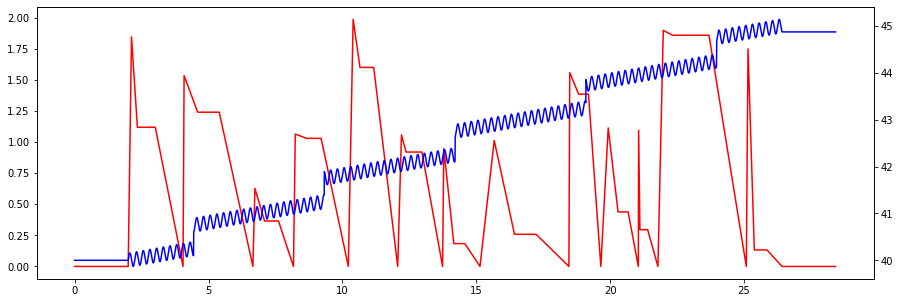

In [11]:
pitch, loudness = my_mother((0.5, 1.5), 13)
show(pitch, loudness)
intervals

In [12]:
part = make_part('cello', pitch, loudness, -2)
audio = generate_audio(**part)
Audio(audio, rate=16000)

In [13]:
parts = []

In [14]:
parts.append(part)

In [15]:
audios = []
for part in parts:
    audios.append(generate_audio(**part))

result = np.zeros(max([len(a) for a in audios]))
for audio in audios:
    result[:len(audio)] += audio

In [16]:
Audio(result, rate=16000)

In [17]:
harmonics = [8,9,10,11,12,13,14,15,16]

In [18]:
harmonics_to_cents(harmonics)

[2.0391000173077485,
 1.8240371213406008,
 1.6500422849992202,
 1.5063705850063058,
 1.3857266090392306,
 1.2829824469981426,
 1.1944280826109726,
 1.1173128526977774]

In [19]:
harmonics = [1, 7/4, 3/2, 13/8, 27/16, 11/4]
random.shuffle(harmonics)
base_midi = 70
base_hz = librosa.midi_to_hz(base_midi)
freqs = [h * base_hz for h in harmonics]
cents = [librosa.hz_to_midi(f) for f in freqs]
gliss_time = 0.1
sus_time = 3
dur = len(harmonics) * time
time = gliss_time + sus_time
pitches = []
pitches.append(constant(time, cents[0]))
for a, b in zip(cents[:-1], cents[1:]):
    pitches.append(line_segment(gliss_time, a, b))
    pitches.append(constant(sus_time, b))

pitches = np.concatenate(pitches)
pitches += sinusoid(dur, 4, 0, 0.15)

loudnesses = []
loudness = triangle(dur, 2/time, highest=line_segment(dur, 4, 1))
loudnesses.append(loudness)

loudness = np.concatenate(loudnesses)
loudness = np.concatenate([loudness, np.zeros(len(pitches) - len(loudness))])

pitches = pad(pitches, 2)
loudness = pad(loudness, 2)

audio = generate_audio('flute', pitches, loudness, db_offset=-12)
Audio(audio, rate=16000)

NameError: name 'time' is not defined

In [ ]:
show(pitches, loudness)